<a href="https://colab.research.google.com/github/whsu2s/nlp/blob/master/named_entity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Named-entity recognition (NER)

The aim is to use two types of word embeddings (Word2Vec, fastText) as the features for the training of named entity recognition, and compare the results.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec, FastText

from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load dataset

In [ ]:
df = pd.read_csv('data/ner_dataset.csv', encoding="latin-1")
data = df.fillna(method='ffill')
print(data.head())
print("There are {} sentences, {} unique words and {} tags.". \
      format(data['Sentence #'].nunique(), data.Word.nunique(), data.Tag.nunique()))

    Sentence #           Word  POS Tag
0  Sentence: 1      Thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O
There are 47959 sentences, 35178 unique words and 17 tags.


In [ ]:
# Most common words in the dataset with number of occurence
most_common_words = pd.Series(' '.join(data['Word']).split()).value_counts()[:20]
most_common_words

the     52573
.       47761
,       32754
of      26354
in      26323
to      23213
a       20481
and     19936
The     11313
's      10923
for      8498
has      7216
is       6746
on       6710
that     6301
have     5485
with     5381
said     5321
was      4878
says     4640
dtype: int64

In [ ]:
# Least common words in the dataset with number of occurence
least_common_words = pd.Series(' '.join(data['Word']).split()).value_counts()[-20:]
least_common_words

panhandle           1
tumultuous          1
12,012              1
Sohail              1
perverted           1
pop-rock            1
1,32,000            1
brawny              1
mundane             1
Zhulyany            1
Mar-93              1
gusting             1
Transnistria        1
Rakhmonov           1
refinement          1
A380                1
Kurdish-majority    1
wreaths             1
Lene                1
Wai                 1
dtype: int64

### Preprocessing: data analysis

In [ ]:
# Tags distribution: 
# 84.7% of the words are not named entity ('O') .
# The most/least common named entities is geographical/natural (3.59%/0.0049%).
n_tags = data['Tag'].nunique()
data['Tag'].value_counts(normalize=True)

O        0.846776
B-geo    0.035900
B-tim    0.019391
B-org    0.019210
I-per    0.016452
B-per    0.016203
I-org    0.016006
B-gpe    0.015135
I-geo    0.007071
I-tim    0.006226
B-art    0.000383
B-eve    0.000294
I-art    0.000283
I-eve    0.000241
B-nat    0.000192
I-gpe    0.000189
I-nat    0.000049
Name: Tag, dtype: float64

In [ ]:
# Real number of each class 
data.groupby('Tag').size().reset_index(name='counts')

,Tag,counts
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


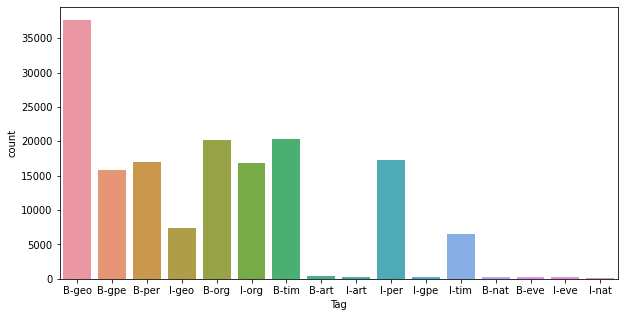

In [ ]:
# Plot showing the number of each named entities ('O' is excluded)
plt.figure(figsize=(10, 5))
ax = sns.countplot('Tag', data=data.loc[df['Tag'] != 'O'])

In [ ]:
# Class for getting the sentences from dataframe
class SentenceGetter(object):
  def __init__(self, data):
    self.n_sent = 1.0
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(), \
                                                 s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]

getter = SentenceGetter(data)
sentences_labeled = getter.sentences  # Sentences with tags
sentences = [[w[0] for w in s] for s in sentences_labeled]  # Sentences without tags
print(len(sentences_labeled))
print(sentences_labeled[0])

47959
[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


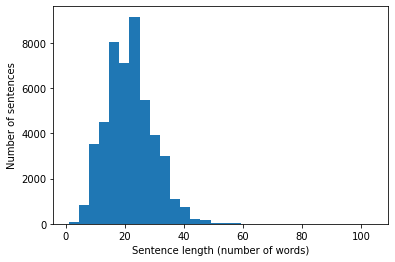

In [ ]:
# Sentence length distribution
plt.hist([len(s) for s in sentences], bins=30)
plt.xlabel('Sentence length (number of words)')
plt.ylabel('Number of sentences')
plt.show()

### Feature extraction: word embeddings (Word2Vec, fastText)
The two embedding models, i.e. Word2Vec, fastText, are compared. The main difference between the two is that fastText considers a word as several n-grams, and may allow better representation of rare words in NLP tasks or even out of vocabulary words. The parameters are set in the same way, and continuous bag of words (CBOW) are used in both cases. The dimension of the embedding and the window size are two variables to be analysed. It is expected that higher dimension can capture more information, and thus results in better performance. The window size affects the relationship between neighboring words, but it may be hard to say which would give better result. 

In [ ]:
# Word2Vec model
model1 = Word2Vec(sentences, min_count=1, size=50, window=5, iter=10)
print(len(model1.wv.vocab))
model1.wv.similarity('London', 'Paris')

35178


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.6955268

In [ ]:
model1.most_similar('man')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.9503031373023987),
 ('family', 0.9134286046028137),
 ('not-guilty', 0.8943654298782349),
 ('Seventy-five', 0.8862839341163635),
 ('parcel', 0.8792161345481873),
 ('kidnappers', 0.8757182955741882),
 ('al-Muqrin', 0.875463604927063),
 ('arrests', 0.8742769956588745),
 ('Fawaz', 0.8706587553024292),
 ('gunman', 0.8660849332809448)]

In [ ]:
model1.most_similar('A380')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Domm', 0.9374496936798096),
 ('Leonidas', 0.936417818069458),
 ('Wing', 0.933006763458252),
 ('Fighter', 0.931567907333374),
 ('A&M', 0.9302983283996582),
 ('Teddy', 0.9302171468734741),
 ('Neng', 0.9300995469093323),
 ('receiver', 0.9295743703842163),
 ('inductee', 0.929154634475708),
 ('fully-loaded', 0.9286773800849915)]

In [ ]:
# FastText model
model2 = FastText(min_count=1, size=50, window=5)  # instantiate
model2.build_vocab(sentences=sentences)
model2.train(sentences=sentences, total_examples=len(sentences), epochs=10)  # train
print(len(model2.wv.vocab))
model2.similarity('London', 'Paris')

35178


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.57917684

In [ ]:
model2.wv.most_similar('man')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('woman', 0.9552904963493347),
 ('snowman', 0.9297089576721191),
 ('corpsman', 0.9280816316604614),
 ('batsman', 0.9246188998222351),
 ('ten-man', 0.9193876385688782),
 ('anchorwoman', 0.9126501083374023),
 ('Huntsman', 0.906972348690033),
 ('10-man', 0.9052087068557739),
 ('40-man', 0.9019542932510376),
 ('Ottoman', 0.9004629850387573)]

In [ ]:
model2.most_similar('A380')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('380', 0.9819229245185852),
 ('A-380', 0.9719002842903137),
 ('57.25', 0.9697685241699219),
 ('356.6', 0.9696081876754761),
 ('1.16', 0.9684793949127197),
 ('1.18', 0.9682021737098694),
 ('10.5', 0.9671025276184082),
 ('1.125', 0.9650313258171082),
 ('126.2', 0.9646373391151428),
 ('40.3', 0.9644663333892822)]

From the similar words shown above, it is hard to say whether Word2Vec or fastText produces better representation of the words. However, it is obvious that fastText tends to relate words with similar patterns, such as 'man' and the number '380'.

In [ ]:
def word2features(word, model):
  """ Transform the given word into word embedding using a embedding model. 
      Choice of model: model1 (Word2Vec), model2 (fastText)
  """
  features = ({'v'+str(i): model[word][i] for i in range(len(model[word]))})
  features.update({'word': word})

  # Rule-based features
  """
  r_features = {
    #'word.lower()': word.lower(),
    #'word.isupper()': word.isupper(),
    #'word.istitle()': word.istitle(),
    'word.isdigit()': word.isdigit()
  } #"""
  #features.update(r_features)

  return features

def sent2tags(sentence):
  """ Map a sentence (list of tuples (word, tag)) into a list of tags for each 
  word in the sentence. 
  """
  return [tag for word, tag in sentence]

### Training for NER

In [ ]:
# Get data for training and test
def get_data(model):
  """ Get training and test data. 
  The (embedding) model can be either model1 (Word2Vec) or model2 (fastText). 
  """
  X = [[w for w in s] for s in sentences]
  X = [[word2features(w, model) for w in s] for s in X]
  y = [sent2tags(s) for s in sentences_labeled]
  # Split data into training and test set with ratio 70/30
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_data(model1)
#X_train, X_test, y_train, y_test = get_data(model2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [ ]:
# Functions for confusion matrix (Source: https://github.com/practical-nlp/practical-nlp/blob/master/Ch5/02_NERTraining.ipynb)
def print_cm(cm, labels):
    print("\n")
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        sum = 0
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            sum =  sum + int(cell)
            print(cell, end=" ")
        print(sum) # Print the total number of instances per cat at the end.

def get_confusion_matrix(y_true,y_pred,labels):
    trues,preds = [], []
    for yseq_true, yseq_pred in zip(y_true, y_pred):
        trues.extend(yseq_true)
        preds.extend(yseq_pred)
    print_cm(confusion_matrix(trues,preds,labels),labels)

In [ ]:
# Conditional random field model
def train_crf(X_train, X_test, y_train, y_test):
  """  """
  crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=20)
  crf.fit(X_train, y_train)
  labels = list(crf.classes_)
  sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))

  # Evaluate on test data
  y_pred = crf.predict(X_test)
  print(flat_classification_report(y_test, y_pred))
  get_confusion_matrix(y_test, y_pred, labels=sorted_labels)

train_crf(X_train, X_test, y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00       172
       B-eve       0.00      0.00      0.00       122
       B-geo       0.81      0.69      0.75     14984
       B-gpe       0.91      0.69      0.79      6380
       B-nat       0.00      0.00      0.00        96
       B-org       0.61      0.34      0.43      8020
       B-per       0.78      0.58      0.67      6836
       B-tim       0.93      0.56      0.70      8270
       I-art       0.00      0.00      0.00       130
       I-eve       0.00      0.00      0.00       101
       I-geo       0.71      0.49      0.58      3029
       I-gpe       0.00      0.00      0.00        86
       I-nat       0.00      0.00      0.00        31
       I-org       0.56      0.54      0.55      6736
       I-per       0.75      0.79      0.77      6895
       I-tim       0.92      0.31      0.46      2677
           O       0.95      0.99      0.97    353150

    accuracy              

### Evaluation
F1 score is used as the metrics to evaluate the result. As the named entities are of interest in NER task, the results of the words with 'O' tag are omitted. 

In [ ]:
# F1 score of different embedding size
f1_w2v = [[0.0, 0.0, 0.0, 0.0, 0.44, 0.39, 0.08, 0.0, 0.0, 0.0, 0.18, 0.35, 0.50, 0.50, 0.62, 0.34],
          [0.0, 0.0, 0.0, 0.0, 0.59, 0.44, 0.61, 0.0, 0.0, 0.0, 0.26, 0.42, 0.60, 0.70, 0.67, 0.41],
          [0.0, 0.0, 0.01, 0.0, 0.65, 0.51, 0.65, 0.0, 0.0, 0.0, 0.30, 0.46, 0.61, 0.66, 0.75, 0.43],
          [0.0, 0.0, 0.0, 0.0, 0.69, 0.53, 0.76, 0.0, 0.0, 0.0, 0.33, 0.50, 0.59, 0.71, 0.75, 0.47]]

f1_ft = [[0.0, 0.0, 0.0, 0.0, 0.07, 0.28, 0.08, 0.0, 0.0, 0.0, 0.04, 0.09, 0.52, 0.46, 0.0, 0.0],
         [0.0, 0.0, 0.0, 0.0, 0.37, 0.37, 0.51, 0.0, 0.0, 0.0, 0.28, 0.38, 0.55, 0.56, 0.36, 0.09],
         [0.0, 0.0, 0.0, 0.0, 0.60, 0.31, 0.69, 0.0, 0.0, 0.0, 0.32, 0.41, 0.61, 0.64, 0.69, 0.18],
         [0.0, 0.0, 0.0, 0.0, 0.70, 0.52, 0.82, 0.0, 0.0, 0.0, 0.33, 0.36, 0.62, 0.66, 0.75, 0.23]]
labels = sorted(data['Tag'].unique(), key=lambda name: (name[1:], name[0])) 
labels.remove('O')

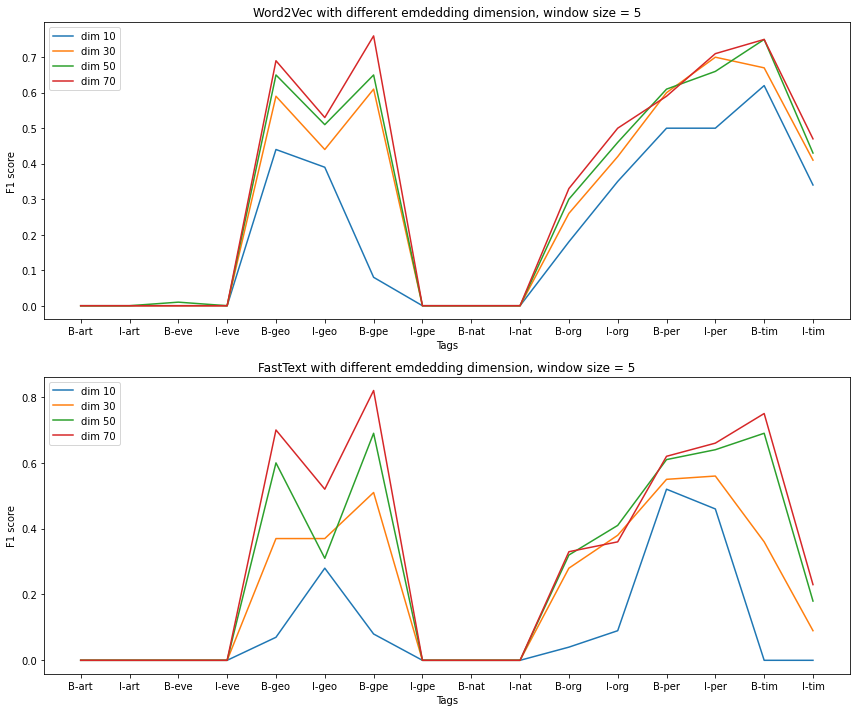

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(range(len(np.array(f1_w2v).T)), np.array(f1_w2v).T)
plt.legend(['dim 10', 'dim 30', 'dim 50', 'dim 70'], loc='upper left')
plt.title('Word2Vec with different emdedding dimension, window size = 5')
plt.xticks(range(len(np.array(f1_w2v).T)), labels)
plt.xlabel('Tags')
plt.ylabel('F1 score')
plt.subplot(212)
plt.plot(range(len(np.array(f1_ft).T)), np.array(f1_ft).T)
plt.legend(['dim 10', 'dim 30', 'dim 50', 'dim 70'], loc='upper left')
plt.title('FastText with different emdedding dimension, window size = 5')
plt.xticks(range(len(np.array(f1_ft).T)), labels)
plt.xlabel('Tags')
plt.ylabel('F1 score')
plt.tight_layout()

In [ ]:
# F1 score of different window size, dim = 50
f1_w2v2 = [[0.0, 0.0, 0.0, 0.0, 0.75, 0.58, 0.79, 0.0, 0.0, 0.0, 0.43, 0.55, 0.67, 0.77, 0.70, 0.46],
          [0.0, 0.0, 0.0, 0.0, 0.68, 0.55, 0.74, 0.0, 0.0, 0.0, 0.41, 0.51, 0.64, 0.72, 0.73, 0.45],
          [0.0, 0.0, 0.01, 0.0, 0.65, 0.51, 0.65, 0.0, 0.0, 0.0, 0.30, 0.46, 0.61, 0.66, 0.75, 0.43]]

f1_ft2 = [[0.0, 0.0, 0.0, 0.0, 0.74, 0.49, 0.80, 0.0, 0.0, 0.0, 0.42, 0.48, 0.67, 0.76, 0.75, 0.46],
         [0.0, 0.0, 0.0, 0.0, 0.69, 0.49, 0.7, 0.0, 0.0, 0.0, 0.35, 0.44, 0.66, 0.72, 0.74, 0.40],
         [0.0, 0.0, 0.0, 0.0, 0.60, 0.31, 0.69, 0.0, 0.0, 0.0, 0.32, 0.41, 0.61, 0.64, 0.69, 0.18]]
labels = sorted(data['Tag'].unique(), key=lambda name: (name[1:], name[0])) 
labels.remove('O')

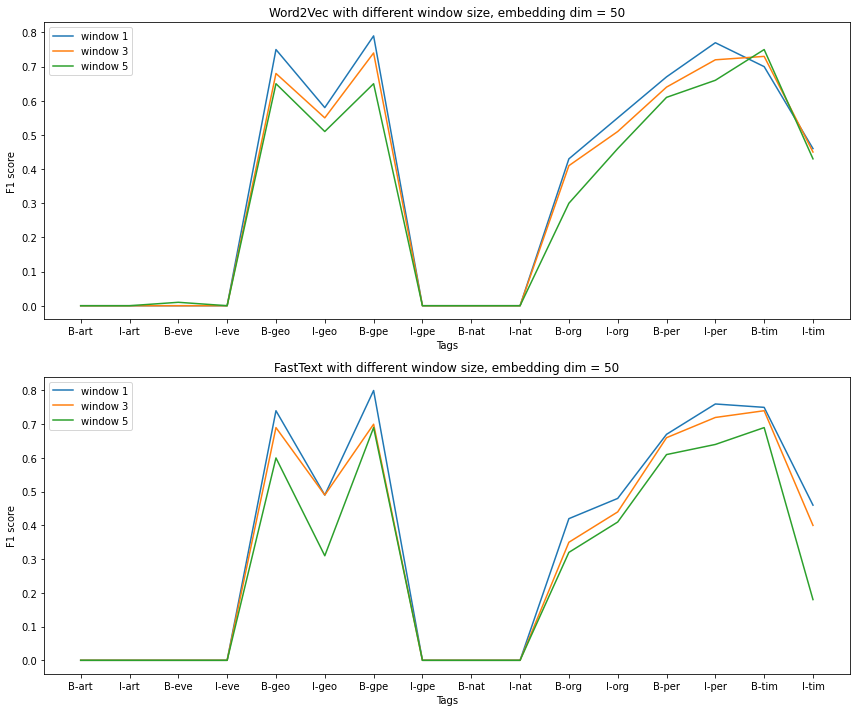

In [ ]:
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(range(len(np.array(f1_w2v2).T)), np.array(f1_w2v2).T)
plt.legend(['window 1', 'window 3', 'window 5'], loc='upper left')
plt.title('Word2Vec with different window size, embedding dim = 50')
plt.xticks(range(len(np.array(f1_w2v2).T)), labels)
plt.xlabel('Tags')
plt.ylabel('F1 score')
plt.subplot(212)
plt.plot(range(len(np.array(f1_ft2).T)), np.array(f1_ft2).T)
plt.legend(['window 1', 'window 3', 'window 5'], loc='upper left')
plt.title('FastText with different window size, embedding dim = 50')
plt.xticks(range(len(np.array(f1_ft2).T)), labels)
plt.xlabel('Tags')
plt.ylabel('F1 score')
plt.tight_layout()

In [ ]:
# Get misclassfied data and save to file "misclassified_data.txt"
%%capture misclassified_data
for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    if y_pred[i][j] != y_test[i][j]:
      sent = [X_test[i][k]['word'] for k in range(len(X_test[i]))]
      print(' '.join(w for w in sent))
      print("{}: True label: {}, predicted label: {}".format(X_test[i][j]['word'], y_test[i][j], y_pred[i][j]))
      print()
m_data = misclassified_data.stdout
%store m_data > misclassified_data.txt


There are several reasons that caused misclassification. An inherent issue is the wrong or inconsistent labels for the data. Another issue is the unbalanced dataset, making the model tend to predict ‘O’ for unusual words. There are some words that may have confused the model: for example, the model predicted “Korean” War as geographic entity (B-geo) instead of event (B-eve). 

In [ ]:
# Example of wrong label: 43 is not a time entity
data[data['Sentence #'] == 'Sentence: 13160']

,Sentence #,Word,POS,Tag
287439,Sentence: 13160,A,DT,O
287440,Sentence: 13160,$,$,O
287441,Sentence: 13160,43,CD,B-tim
287442,Sentence: 13160,million,CD,O
287443,Sentence: 13160,contract,NN,O
287444,Sentence: 13160,has,VBZ,O
287445,Sentence: 13160,been,VBN,O
287446,Sentence: 13160,awarded,VBN,O
287447,Sentence: 13160,by,IN,O
287448,Sentence: 13160,the,DT,O


### Summary
Named entity recognition (NER), an important task in information extraction, aims to identify entities such as names of people and organisations in a text. To pipeline of building an NER model is explained as follows:

1. Data acquisition: 

The first step is to download the data “ner_dataset.csv” from "https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus", and load it into the system. 
 
2. Preprocessing: 

Each word falls into one of the 17 tags (labels) indicating the type of entity. Of the 17 tags, there are three main tags: B, I and O. Through explorative data analysis, the dataset is not evenly distributed, as 84.7% of the words are not name entities (label ‘O’). ‘B-geo’ is the most common entities (about 35.9%) in the dataset. The data are transformed into a list of sentences for feature extraction.

3. Feature extraction: 

Two types of word embeddings are used as the features, i.e. Word2Vec and fastText. The word and its embedding are combined as the features for the training of NER. The pre-trained models of the embeddings are used. The dimension of the word embeddings is used as a variable of the experiment.  

4. Model training: 

Conditional random field (CRF) model is selected for training, as it is one of the most commonly used algorithms for NER. The dataset is divided into training and test set with a ratio of 70 to 30. 

5. Evaluation:

From the plots above, the F1 score generally increases with the dimension of the word embeddings, but decreases with the window size. Due to the scarcity of data, the model failed to correctly predict the minor classes, e.g. B-art. Comparing the results of using two embedding models Word2Vec and fastText as features, there is no obvious difference except that the FastText shows larger boost in F1 score with increasing dimension of embedding. Although word embeddings already contain relevant contextual information, the actual meaning may vary. Hence, the choice of the embedding dimension and window size as well as the training of the embedding models are important. Besides, NLP tasks are usually domain-specific, so rule-based features may help.